## Imports

In [34]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Criando o cenario

In [110]:
# df = pd.read_csv("")
df = pd.DataFrame(
    {"cliente": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
     "feature-1": [100, 150, 200, 140, 150, 140, 230, 400, 260, 165],
     "prediction": [0.1, 0.4, 0.7, 0.15, 0.45, 0.32, 0.13, 0.28, 0.65, 0.43],
     "target": [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    "transaction_amount": [150.0, 500.0, 20.0, 30.0, 120, 500.0, 30.0, 20.0, 40.0, 20.0],
    "international_transaction": [0, 1, 0, 0, 0, 1, 0, 0, 0, 0]}
)


df

,cliente,feature-1,prediction,target,transaction_amount,international_transaction
0,1,100,0.10,0,150.0,0
1,2,150,0.40,1,500.0,1
2,3,200,0.70,0,20.0,0
3,4,140,0.15,0,30.0,0
4,5,150,0.45,0,120.0,0
5,6,140,0.32,0,500.0,1
6,7,230,0.13,0,30.0,0
7,8,400,0.28,0,20.0,0
8,9,260,0.65,0,40.0,0
9,10,165,0.43,0,20.0,0


In [54]:
review_fraud_cost = 1.0
interchange_revenue = 0.015
target_col = "target"
prediction_col = "prediction"
amount_col = "transaction_amount"

## Metricas basicas recap
Como temos um problema de classificação, vamos focar nas metricas basicas de classificação AUC, Logloss, Matriz de Confusão

In [31]:
from sklearn.metrics import auc, log_loss, roc_curve, confusion_matrix

In [28]:
fpr, tpr, thresholds = roc_curve(df[target_col], df[prediction_col])
auc(fpr, tpr)

0.5238095238095238

In [29]:
log_loss(df[target_col], df[prediction_col])

0.6677662400862899

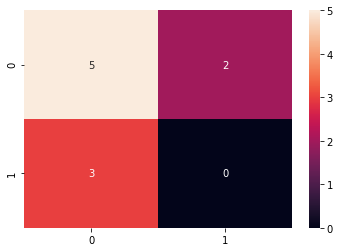

In [36]:
threshold = 0.5 # definindo um threshold arbitrario pra gerar a matrix de confusao
# o estudo de thresholds vira na sequencia
cf_matrix = confusion_matrix(df[target_col], df[prediction_col] > threshold)
sns.heatmap(cf_matrix, annot=True)

## Validação na vida real

Como mencionado nos slides, se dois grupos diferentes tem comportamentos diferentes ou impactam o negócio de maneira distinta, é fundamental avaliar a performance de ambos separadamente

In [85]:
national_df = df.loc[df.international_transaction == 0]
fpr_national, tpr_national, thresholds_national = roc_curve(national_df[target_col], national_df[prediction_col])
auc(fpr_national, tpr_national)

/Users/henriquelopes/miniconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


nan

In [86]:
international_df = df.loc[df.international_transaction == 1]
fpr_international, tpr_international, thresholds_international = roc_curve(international_df[target_col], international_df[prediction_col])
auc(fpr_international, tpr_international)

1.0

## Definindo um threshold
Aqui desejamos achar um corte que maximize a nossa lucrativade

Primeiro, vamos definir uma função pra calcular o custo de um conjunto de decisões

Depois, podemos gerar todos os thresholds possiveis e qual seria o label de cada transação nesse caso

In [129]:
def profit_from_decision(decision_df):
    # decision_df must have a column `is_fraud` indicating the decision
    # target represents the true information if that transaction was a fraud or not
    # transaction_amount is used to calculate revenues and costs
    return decision_df.assign(
     operational_cost = lambda df: df.is_fraud * review_fraud_cost,
     fraud_losses = lambda df: (~df.is_fraud & df.target) * df.transaction_amount,
     revenues = lambda df: (~df.is_fraud & ~df.target) * df.transaction_amount * interchange_revenue,
     profit = lambda df: df.revenues - (df.fraud_losses + df.operational_cost)
    )[["operational_cost", "fraud_losses", "revenues", "profit"]].sum()

In [141]:
possible_thresholds = np.arange(0.0, 1.0, 0.01)
all_decisions = []
for threshold in possible_thresholds: 
    all_decisions.append(profit_from_decision(df.assign(is_fraud=lambda df: df.prediction >= threshold)))
    

threshold_evaluation = pd.concat(all_decisions, axis=1, keys=[s for s in possible_thresholds]).T.rename_axis("threshold").reset_index()

threshold_evaluation.head(5)

,threshold,operational_cost,fraud_losses,revenues,profit
0,0.00,10.0,0.0,0.0,-10.0
1,0.01,10.0,0.0,0.0,-10.0
2,0.02,10.0,0.0,0.0,-10.0
3,0.03,10.0,0.0,0.0,-10.0
4,0.04,10.0,0.0,0.0,-10.0


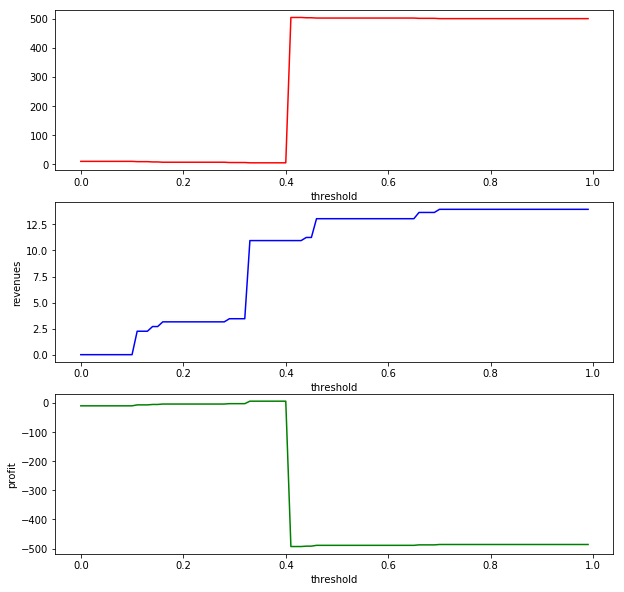

In [142]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

sns.lineplot(threshold_evaluation.threshold, threshold_evaluation.operational_cost + threshold_evaluation.fraud_losses, color="r", ax=ax[0])
sns.lineplot(threshold_evaluation.threshold, threshold_evaluation.revenues, color="b", ax=ax[1])
sns.lineplot(threshold_evaluation.threshold, threshold_evaluation.profit, color="g", ax=ax[2])

# plt.title("Costs (g), Revenues (b), Profit (r)")

In [146]:
best_decision = threshold_evaluation.loc[lambda df: df["profit"].idxmax()]
best_decision

threshold            0.33
operational_cost     5.00
fraud_losses         0.00
revenues            10.95
profit               5.95
Name: 33, dtype: float64

## Calibrando um modelo

Para construção de um modelo de negócio que utilize as probabilidades, é fundamental que essas probabilidades estejam calibradas com o target

### Calibração

In [143]:
from fklearn.training.calibration import isotonic_calibration_learner

isotonic_calibration_fn, transformed_df, logs = isotonic_calibration_learner(df)
transformed_df

,cliente,feature-1,prediction,target,transaction_amount,international_transaction,calibrated_prediction
0,1,100,0.10,0,150.0,0,0.0
1,2,150,0.40,1,500.0,1,0.2
2,3,200,0.70,0,20.0,0,0.2
3,4,140,0.15,0,30.0,0,0.0
4,5,150,0.45,0,120.0,0,0.2
5,6,140,0.32,0,500.0,1,0.0
6,7,230,0.13,0,30.0,0,0.0
7,8,400,0.28,0,20.0,0,0.0
8,9,260,0.65,0,40.0,0,0.2
9,10,165,0.43,0,20.0,0,0.2


### Gerando o ponto otimo da curva de otimização

In [106]:

transaction_amounts = np.arange(10, 20000, 10)
break_even_p = []
for amount in transaction_amounts:
    break_even_p.append(max((0, amount * interchange_revenue - review_fraud_cost)/ (amount * (1 + interchange_revenue))))
    
    
breakeven_df = pd.DataFrame(
    {"transaction_amount": transaction_amounts,
    "probability": break_even_p}
)

breakeven_df.head(10)

,transaction_amount,probability
0,10,0.000000
1,20,0.000000
2,30,0.000000
3,40,0.000000
4,50,0.000000
5,60,0.000000
6,70,0.000704
7,80,0.002463
8,90,0.003831
9,100,0.004926


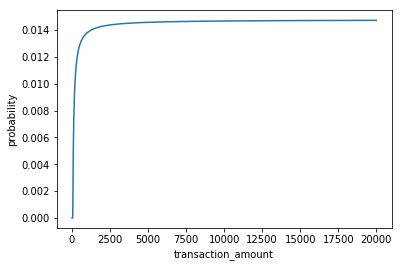

In [107]:
sns.lineplot(breakeven_df.transaction_amount, breakeven_df.probability)

### Calculando a lucratividade dessa otimização

In [149]:
profit_from_decision(transformed_df.merge(breakeven_df, on="transaction_amount", how="left")
.assign(is_fraud=lambda df: df.calibrated_prediction > df.probability)
)

operational_cost     5.00
fraud_losses         0.00
revenues            10.95
profit               5.95
dtype: float64

## Criando bandas de modelo

### Bandas de mesma largura

In [70]:
band_size = 0.1
binned_df = df.assign(prediction_band = lambda df: np.floor(df.prediction / band_size))
binned_df

,cliente,feature-1,prediction,target,transaction_amount,international_transaction,prediction_band
0,1,100,0.10,0,150.0,0,1.0
1,2,150,0.40,1,500.0,1,4.0
2,3,200,0.70,0,2.0,0,6.0
3,4,140,0.15,0,30.0,0,1.0
4,5,150,0.45,0,120.0,0,4.0
5,6,140,0.32,0,500.0,1,3.0
6,7,230,0.13,0,32.0,0,1.0
7,8,400,0.28,0,24.0,0,2.0
8,9,260,0.65,0,45.0,0,6.0
9,10,165,0.43,0,22.0,0,4.0


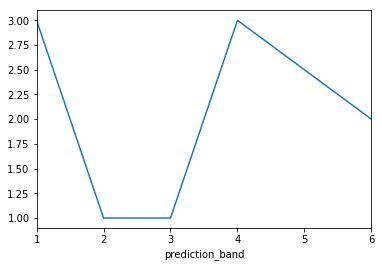

In [69]:
binned_df.groupby("prediction_band").count().cliente.plot()

### Bandas de mesma quantidade de clientes

In [71]:
## This function is not "learning" how to band and we can't apply the same rule to new clients
number_of_bands = 3
df.assign(bands= lambda df: pd.qcut(df.prediction, number_of_bands, labels=[1,2,3]),
         bands_ranges= lambda df: pd.qcut(df.prediction, number_of_bands),)

,cliente,feature-1,prediction,target,transaction_amount,international_transaction,bands,bands_ranges
0,1,100,0.10,0,150.0,0,1,"(0.099, 0.28]"
1,2,150,0.40,1,500.0,1,2,"(0.28, 0.43]"
2,3,200,0.70,0,2.0,0,3,"(0.43, 0.7]"
3,4,140,0.15,0,30.0,0,1,"(0.099, 0.28]"
4,5,150,0.45,0,120.0,0,3,"(0.43, 0.7]"
5,6,140,0.32,0,500.0,1,2,"(0.28, 0.43]"
6,7,230,0.13,0,32.0,0,1,"(0.099, 0.28]"
7,8,400,0.28,0,24.0,0,1,"(0.099, 0.28]"
8,9,260,0.65,0,45.0,0,3,"(0.43, 0.7]"
9,10,165,0.43,0,22.0,0,2,"(0.28, 0.43]"


In [18]:
from fklearn.training.transformation import discrete_ecdfer
discrete_ecdfer?

In [19]:
predict_fn, transformed_df, _ = discrete_ecdfer(df, max_range=3)
transformed_df 

,cliente,feature-1,prediction,prediction_ecdf
0,1,100,0.10,0
1,2,150,0.40,1
2,3,200,0.70,3
3,4,140,0.15,0
4,5,150,0.45,2
5,6,140,0.32,1
6,7,230,0.13,0
7,8,400,0.28,1
8,9,260,0.65,2
9,10,165,0.43,2


In [20]:
## predict_fn "learns" how to apply the transformation and can be reapplied to any dataframe
predict_fn(df)

,cliente,feature-1,prediction,prediction_ecdf
0,1,100,0.10,0
1,2,150,0.40,1
2,3,200,0.70,3
3,4,140,0.15,0
4,5,150,0.45,2
5,6,140,0.32,1
6,7,230,0.13,0
7,8,400,0.28,1
8,9,260,0.65,2
9,10,165,0.43,2


### Regra baseada em grupos pre definidos

In [150]:
profit_from_decision(transformed_df.assign(is_fraud=lambda df: 
                      np.where(df.calibrated_prediction < 0.1, 0, 
                               np.where((df.calibrated_prediction >= 0.1) & (df.calibrated_prediction < 0.4) & (df.transaction_amount < 1000), 0, 1))
))

operational_cost      0.00
fraud_losses        500.00
revenues            -28.95
profit             -528.95
dtype: float64